In [33]:
!pip -q install torch torchvision matplotlib

In [34]:
import os

import torch
from torch import nn
from torch.utils import data
from torch.nn.modules.utils import _pair

from torchvision import transforms

from PIL import Image

from matplotlib import pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device : {device}")

Using device : cuda


In [35]:
class SelfAttention(nn.Module):

  def __init__(self, embed_size, num_heads):

    super(SelfAttention, self).__init__()

    self.embed_size = embed_size
    self.num_heads = num_heads
    self.head_dim = embed_size // num_heads

    assert (self.head_dim * num_heads == embed_size), "Embed size needs to be divisible by heads"

    self.values = nn.Linear(self.head_dim, self.head_dim, bias = False)
    self.keys = nn.Linear(self.head_dim, self.head_dim, bias = False)
    self.queries = nn.Linear(self.head_dim, self.head_dim, bias = False)
    self.fc_out = nn.Linear(num_heads * self.head_dim, embed_size)


  def forward(self, keys, query, values, mask):
    N = query.shape[0]
    value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

    # Split embedding into self.num_heads pieces
    values = values.reshape(N, value_len, self.num_heads, self.head_dim)
    keys = keys.reshape(N, key_len, self.num_heads, self.head_dim)
    queries = query.reshape(N, query_len, self.num_heads, self.head_dim)

    values = self.values(values)
    keys = self.keys(keys)
    queries = self.queries(queries)

    energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys]) # MatMul Q and K
    # queries shape: (N, query_len, heads, heads_dim)
    # keys shape: (N, query_len, heads, heads_dim)
    # energy shape: (N, heads, query_len, key_len)

    # if mask is not None:
    #   energy = energy.masked_fill(mask == 0, float("-1e20"))

    attention = torch.softmax(energy / (self.embed_size ** 0.5), dim = 3)

    out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
      N, query_len, self.num_heads * self.head_dim
    )
 
    out = self.fc_out(out)

    return out


In [36]:
class TransformerBlock(nn.Module):

  def __init__(
    self,
    embed_size = 480,
    num_heads = 4,
    hidden_dim = 4096
  ):
    super(TransformerBlock, self).__init__()

    self.layer_norm = nn.LayerNorm(embed_size)

    self.attention = SelfAttention(embed_size, num_heads)

    self.feed_forward = nn.Sequential(
      nn.Linear(embed_size, hidden_dim),
      nn.GELU(),
      # nn.Dropout(),
      nn.Linear(hidden_dim, embed_size),
      # nn.Dropout()
    )


  def forward(self, key, query, value, mask):
    norm_out = self.layer_norm(input)

    attention_out = self.attention(norm_out, norm_out, norm_out)

    out = attention_out + input

    norm_out2 = self.layer_norm(out)

    feed_forward_out = self.feed_forward(norm_out2)

    return out + feed_forward_out

In [37]:
class Attention_org(nn.Module):
  def __init__(self, vis, channel_num, KV_size=480, num_heads=4):
    super(Attention_org, self).__init__()
    self.KV_size = KV_size
    self.channel_num = channel_num
    self.num_attention_heads = num_heads
    
    self.query = nn.ModuleList()

    for _ in range(num_heads):
      # multiple attention heads.
      self.query.append(copy.deepcopy(nn.Linear(channel_num[0], channel_num[0], bias=False)))


    self.key = nn.Linear( self.KV_size, self.KV_size, bias=False)
    self.value = nn.Linear(self.KV_size, self.KV_size, bias=False)

    self.psi = nn.InstanceNorm2d(self.num_attention_heads)

    self.softmax = Softmax(dim=3)

    self.out0 = nn.Linear(channel_num[0], channel_num[0], bias=False)


  def forward(self, emb1, emb_all):
    multi_head_Q1_list = []
    multi_head_K_list = []
    multi_head_V_list = []

    for query1 in self.query1:
      # Passing embedding through all heads.
      Q1 = query1(emb1)
      multi_head_Q1_list.append(Q1)

    for key in self.key:
      # all embedding concated.
      K = key(emb_all)
      multi_head_K_list.append(K)

    for value in self.value:
      V = value(emb_all)
      multi_head_V_list.append(V)


    multi_head_Q1 = torch.stack(multi_head_Q1_list, dim=1) if emb1 is not None else None
    multi_head_K = torch.stack(multi_head_K_list, dim=1)
    multi_head_V = torch.stack(multi_head_V_list, dim=1)

    multi_head_Q1 = multi_head_Q1.transpose(-1, -2) if emb1 is not None else None

    attention_scores1 = torch.matmul(multi_head_Q1, multi_head_K) if emb1 is not None else None

    attention_scores1 = attention_scores1 / math.sqrt(self.KV_size) if emb1 is not None else None

    attention_probs1 = self.softmax(self.psi(attention_scores1)) if emb1 is not None else None

    attention_probs1 = self.attn_dropout(attention_probs1) if emb1 is not None else None

    multi_head_V = multi_head_V.transpose(-1, -2)
    context_layer1 = torch.matmul(attention_probs1, multi_head_V) if emb1 is not None else None

    context_layer1 = context_layer1.permute(0, 3, 2, 1).contiguous() if emb1 is not None else None
    context_layer1 = context_layer1.mean(dim=3) if emb1 is not None else None

    O1 = self.out1(context_layer1) if emb1 is not None else None
    O1 = self.proj_dropout(O1) if emb1 is not None else None

    return O1, weights



In [38]:
class Transformer(nn.Module):

  def __init__(
    self,
    num_heads
  ):
    super(Transformer, self).__init__()

    self.multiple_heads = [TransformerBlock() for _ in range(num_heads)]


  def forward(self, inputs):
    multi_head_attentions = [head(inputs) for head in self.multiple_heads]

    return multi_head_attentions(input)


In [39]:
class ChannelEmbedding(nn.Module):
  """
    Construct the embeddings from patch and position embeddings.
  """

  def __init__(
    self,
    patch_size,
    image_size,
    in_channels
  ):
    super(ChannelEmbedding, self).__init__()

    image_size = _pair(image_size)
    patch_size = _pair(patch_size)

    n_patches = (image_size[0] // patch_size[0]) * (image_size[1] // patch_size[1])

    self.patch_embeddings = nn.Conv2d(in_channels, in_channels, patch_size, patch_size)

    self.position_embedding = nn.Parameter(
      torch.zeros(n_patches, in_channels))

  
  def forward(self, input):
    patch_embeddings = self.patch_embeddings(input)

    flatten_patches = patch_embeddings.flatten(2)

    flatten_patches = flatten_patches.transpose(-1, -2)

    return flatten_patches + self.position_embedding


In [40]:
class CSMHA(nn.Module):

  def __init__(
    self,
    channel_num,
    num_heads = 4
  ):
    super(CSMHA, self).__init__()

    self.transformer = Transformer(num_heads)


  def forward(self, inputs):

    return self.transformer(inputs)

    # normalized_inputs = [self.channel_wise_layer_norm[i](inputs[i]) for i in range(self.num_layers)]

In [41]:
class CMSFFT(nn.Module):

  def __init__(
    self,
    image_size = 256,
    channel_num = [32, 64, 128, 256],
    patch_size = [32, 16, 8, 4],
    num_channels = 4
  ):
    super(CMSFFT, self).__init__()

    self.num_channels = num_channels
    self.embeddings = [ChannelEmbedding(patch_size[i], image_size // pow(2, i), channel_num[i]) for i in range(self.num_channels)]

    self.cmha_layers = [CSMHA(channel_num) for _ in range(num_channels)]


  def forward(self, inputs):

    # for input in inputs:
    #   print(input.shape)

    embeddings = [self.embeddings[i](inputs[i]) for i in range(self.num_channels)]

    for ix, embedding in enumerate(embeddings):
      print(f'Embedding {ix + 1}: {embedding.shape}')

    cmha_output = [layer(self.embeddings) for layer in self.cmha_layers]

    return cmha_output


In [42]:
class SGFMT(nn.Module):

  def __init__(self):
    pass

  
  def forward(self, x):
    pass

In [43]:
class UShapeTransformer(nn.Module):

  def __init__(
    self,
    image_size = 256,
    in_channels = 3,
    kernel_size = 3,
    max_pool_window_size = 2
  ):
    super(UShapeTransformer, self).__init__()

    # input image size (256X256)
    self.max_pool = nn.MaxPool2d(max_pool_window_size)

    self.conv1 = nn.Conv2d(in_channels, 16, kernel_size, padding = 'same')
    self.conv1_1 = nn.Conv2d(16, 32, kernel_size, padding = 'same')

    self.conv2 = nn.Conv2d(32, 32, kernel_size, padding = 'same')
    self.conv2_1 = nn.Conv2d(32, 64, kernel_size, padding = 'same')

    self.conv3 = nn.Conv2d(64, 64, kernel_size, padding = 'same')
    self.conv3_1 = nn.Conv2d(64, 128, kernel_size, padding = 'same')

    self.conv4 = nn.Conv2d(128, 128, kernel_size, padding = 'same')
    self.conv4_1 = nn.Conv2d(128, 256, kernel_size, padding = 'same')

    self.CMSFFT = CMSFFT()


  def forward(self, input):
    conv1_output = self.conv1_1(self.conv1(input))
    # conv1: 256 * 256 * 3 -> 256 * 256 * 16
    # conv1_1: 256 * 256 * 16 -> 256 * 256 * 32

    conv2_output = self.conv2_1(self.conv2(self.max_pool(conv1_output)))
    # max_pool : 128 * 128 * 32
    # # conv2 : 128 * 128 * 32 -> 128 * 128 * 32 1x1 convolution
    # conv2_1 : 128 * 128 * 32 -> 128 * 128 * 64


    conv3_output = self.conv3_1(self.conv3(self.max_pool(conv2_output)))
    # max_pool : 64 * 64 * 64
    # conv3 : 64 * 64 * 64 -> 64 * 64 * 64 1x1 convolution
    # conv3_1 : 64 * 64 * 64 -> 64 * 64 * 128
    

    conv4_output = self.conv4_1(self.conv4(self.max_pool(conv3_output)))
    # max_pool : 64 * 64 * 128 -> 32 * 32 * 128
    # conv4 : 32 * 32 * 128 -> 32 * 32 * 128 1x1 convolution
    # conv4_1 : 32 * 32 * 128 -> 32 * 32 * 256

    print('conv1_output : ', conv1_output.shape)
    print('conv2_output : ', conv2_output.shape)
    print('conv3_output : ', conv3_output.shape)
    print('conv4_output : ', conv4_output.shape)

    cmsfft_output = self.CMSFFT([
      conv1_output, conv2_output, conv3_output, conv4_output])

    return cmsfft_output

In [44]:
class Dataset(data.Dataset):

  def __init__(
    self,
    root_folder = './uieb_data/',
    type = "train",
    crop_size = 256,
    train_list_path = './uieb_data/uie_train_list.txt',
    test_list_path = './uieb_data/uie_test_list.txt'
  ):
    self.raw_path = root_folder + 'raw-890/'
    self.gt_path = root_folder + 'reference-890/'
    self.crop_size = crop_size

    self.type = type
    
    if self.type == 'train':
      f = open(train_list_path)
    elif self.type == 'test' or self.type == 'valid':
      f = open(test_list_path)

    self.filenames = f.readlines()


  def __getitem__(self, item):

    raw_item_path = os.path.join(
      self.raw_path, self.filenames[item].rstrip())
    gt_item_path = os.path.join(
      self.gt_path, self.filenames[item].rstrip())

    raw_img = Image.open(raw_item_path)
    gt_img = Image.open(gt_item_path)

    transform = transforms.Compose([
      transforms.Resize((self.crop_size, self.crop_size)),
      transforms.ToTensor()
    ])

    return {
      'raw_img': transform(raw_img),
      'gt_img': transform(gt_img)
    }

  def __len__(self):
    return len(self.filenames)


In [45]:
uieb_dataset = Dataset()

dataloader = data.DataLoader(uieb_dataset, batch_size = 1, shuffle = True)

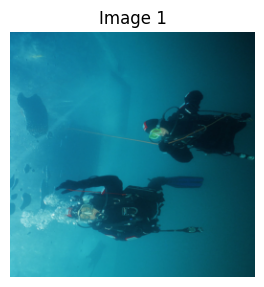

In [46]:
raw_image_batch = next(iter(dataloader))['raw_img']

fig = plt.figure(figsize = (10, 7))

rows, columns = 2, 2

for ix, image in enumerate(raw_image_batch):
  ax = fig.add_subplot(rows, columns, ix + 1)
  ax.set_title('Image ' + str(ix + 1))
  plt.axis('off')
  plt.imshow(image.permute(2, 1, 0))

In [47]:
in_channels = 3
kernel_size = 3

model = UShapeTransformer()

conv1_output :  torch.Size([1, 32, 256, 256])
conv2_output :  torch.Size([1, 64, 128, 128])
conv3_output :  torch.Size([1, 128, 64, 64])
conv4_output :  torch.Size([1, 256, 32, 32])
Embedding 1: torch.Size([1, 64, 32])
Embedding 2: torch.Size([1, 64, 64])
Embedding 3: torch.Size([1, 64, 128])
Embedding 4: torch.Size([1, 64, 256])
[ChannelEmbedding(
  (patch_embeddings): Conv2d(32, 32, kernel_size=(32, 32), stride=(32, 32))
), ChannelEmbedding(
  (patch_embeddings): Conv2d(64, 64, kernel_size=(16, 16), stride=(16, 16))
), ChannelEmbedding(
  (patch_embeddings): Conv2d(128, 128, kernel_size=(8, 8), stride=(8, 8))
), ChannelEmbedding(
  (patch_embeddings): Conv2d(256, 256, kernel_size=(4, 4), stride=(4, 4))
)]
[ChannelEmbedding(
  (patch_embeddings): Conv2d(32, 32, kernel_size=(32, 32), stride=(32, 32))
), ChannelEmbedding(
  (patch_embeddings): Conv2d(64, 64, kernel_size=(16, 16), stride=(16, 16))
), ChannelEmbedding(
  (patch_embeddings): Conv2d(128, 128, kernel_size=(8, 8), stride=(8, 

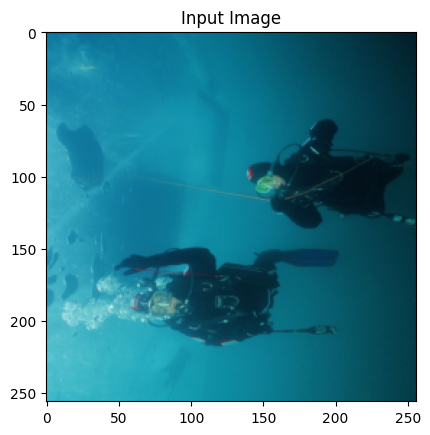

In [48]:
test_image = raw_image_batch[0]

plt.title('Input Image')
plt.imshow(test_image.permute(2, 1, 0))

result = model.forward(raw_image_batch)

# fig = plt.figure(figsize = (20, 25))

# rows, columns = 7, 7

# for ix, channel in enumerate(result):
#   ax = fig.add_subplot(rows, columns, ix + 1)
#   ax.set_title('Channel ' + str(ix))

#   plt.imshow(channel.detach().numpy(), cmap='Greys')